数据集的长度： 259


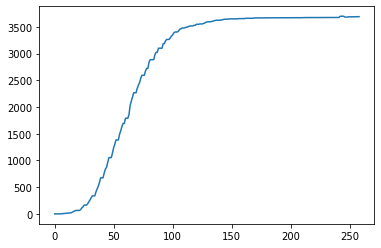

原始训练集的长度： 207
原始测试集的长度： 52
转为监督学习，训练集数据长度： 199
转为监督学习，测试集数据长度： 44
构造得到模型的输入数据(训练数据已有标签trainY):  (199, 1, 1, 7) (44, 1, 1, 7)
Epoch 1/100
7/7 [==============================] - 2s 2ms/step - loss: 0.5302
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 0.4459
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 0.3470
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2341
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 0.1161
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 0.0286
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 0.0117
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 0.0070
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 11/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch 12/100
7/

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_87 (TimeDi  (None, 1, 1, 64)         512       
 stributed)                                                      
                                                                 
 time_distributed_88 (TimeDi  (None, 1, 1, 64)         0         
 stributed)                                                      
                                                                 
 time_distributed_89 (TimeDi  (None, 1, 64)            0         
 stributed)                                                      
                                                                 
 lstm_29 (LSTM)              (None, 4)                 1104      
                                                                 
 dense_29 (Dense)            (None, 1)                 5         
                                                                 
Total para

In [36]:
#单变量，1---》1 

import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#matplotlib inline

# load the dataset
dataframe = read_csv('D://毕业设计//Data//Forecasting//DEU_1day.csv', usecols=[2], engine='python')
# print(dataframe)
print("数据集的长度：",len(dataframe))
dataset = dataframe.values
# 将整型变为float
dataset = dataset.astype('float32')

plt.plot(dataset)
plt.show()


# X是给定时间(t)的乘客人数，Y是下一次(t + 1)的乘客人数。
# 将值数组转换为数据集矩阵,look_back是步长。
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        # X按照顺序取值
        dataX.append(a)
        # Y向后移动一位取值
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

# fix random seed for reproducibility
numpy.random.seed(7)


# 数据缩放
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)


# 将数据拆分成训练和测试，2/3作为训练数据
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print("原始训练集的长度：",train_size)
print("原始测试集的长度：",test_size)



# 构建监督学习型数据
look_back = 7
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back) 
print("转为监督学习，训练集数据长度：", len(trainX))
# print(trainX,trainY)
print("转为监督学习，测试集数据长度：",len(testX))
# print(testX, testY )
# 数据重构为4D [samples, subsequences, timesteps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1,1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0],1, 1, testX.shape[1]))
print('构造得到模型的输入数据(训练数据已有标签trainY): ',trainX.shape,testX.shape)

# create and fit the LSTM network
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(None,1, testX.shape[1]))))
model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(4,activation='relu'))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.fit(trainX, trainY, epochs=100)

# 打印模型
model.summary()

# 开始预测
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)



testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score:',testScore)
from sklearn import metrics
print('Test MAE:',metrics.mean_absolute_error(testY, testPredict[:, 0]))
# 逆缩放预测值
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])



# 计算误差
# trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
# print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
from sklearn import metrics
print('Test MAE:',metrics.mean_absolute_error(testY[0], testPredict[:, 0]))




In [38]:
import pandas as pd
print(testPredict[:, 0])
data = pd.DataFrame(testPredict)
writer = pd.ExcelWriter('D://毕业设计//Data//Forecasting//result//DEU.xlsx')		# 写入Excel文件
data.to_excel(writer, 'page_1', float_format='%.5f')		# ‘page_1’是写入excel的sheet名
writer.save()
writer.close()

[3675.445  3675.5112 3675.9873 3676.1836 3676.0298 3676.336  3676.4526
 3676.5571 3676.5906 3676.8284 3676.9268 3676.8494 3676.8494 3676.8494
 3676.8494 3676.8494 3676.8494 3676.8494 3676.8494 3677.156  3677.2742
 3677.3777 3677.4106 3677.649  3677.7473 3677.6694 3677.6694 3677.6694
 3677.6694 3684.9116 3687.7573 3689.9658 3690.5513 3691.1226 3691.506
 3688.0566 3689.1692 3686.138  3684.9575 3686.2046 3687.7024 3688.307
 3688.0356 3688.689 ]


<ipython-input-38-852167b01257>:4: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.8' currently installed).
  writer = pd.ExcelWriter('D://毕业设计//Data//Forecasting//result//DEU.xlsx')		# 写入Excel文件
<ipython-input-38-852167b01257>:6: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


In [ ]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

fig, ax = plt.subplots(figsize=(10,5),dpi = 300)
plt.plot(scaler.inverse_transform(dataset))
# plt.plot(trainPredictPlot)
# plt.plot(testPredictPlot)
ax.plot( trainPredictPlot, linewidth=2.0,label = "trainpredict")
ax.plot( testPredictPlot, linewidth=2.0,label = "testpredict")
ax.legend(loc=2);
plt.xlabel('Day')
plt.ylabel('Case')
# plt.ylim((0, 10))
plt.grid(linestyle='-.')
plt.title('Global Case-CNNLSTM')
plt.savefig("D://毕业设计//result//预测//Cnn-LSTM//Global Case.png",bbox_inches = 'tight')
plt.show()
# # plot baseline and predictions
# plt.plot(scaler.inverse_transform(dataset))
# plt.plot(trainPredictPlot)
# plt.plot(testPredictPlot)
# plt.show()